# Module 4 Session 6 - Modeling social determinants of health
## Author: Sonali Gupta
### Date: May 29, 2024
# Section 1 - Data exploration

In [42]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')

If any of the above packages are unavailable, they can be installed like so:

install.packages('package_name')

In [43]:
# Load the files for our cohort.
cohort = as.data.frame(fread("../Data/Session6/ParticipantCohort-iSDI.tsv"))
range(cohort$ParticipantID)
dim(cohort)
head(cohort)

T2D = as.data.frame(fread("../Data/Session6/T2D.tsv"))
dim(T2D)
head(T2D)

[1] 10002913 99998921

[1] 50000     5

,ParticipantID,SIRE,Sex,iSDI,Age
,<int>,<chr>,<chr>,<dbl>,<int>
1,10002913,White,F,-0.31416876,56
2,10004024,White,F,0.07031788,45
3,10004283,White,F,0.55632367,48
4,10008277,Hispanic,M,0.52996599,69
5,10008516,Hispanic,M,0.60678931,44
6,10009190,White,F,0.36417263,53


[1] 50000     2

,ParticipantID,t2d
,<int>,<int>
1,10002913,1
2,10004024,0
3,10004283,0
4,10008277,1
5,10008516,0
6,10009190,0


In [44]:
#Explore the data a little bit.
cohort %>% count(SIRE, Sex)
cohort %>% group_by(SIRE, Sex) %>% summarize(MeanAge = mean(Age))

SIRE,Sex,n
<chr>,<chr>,<int>
Black,F,4654
Black,M,2775
Hispanic,F,7455
Hispanic,M,2971
White,F,20273
White,M,11872


`summarise()` has grouped output by 'SIRE'. You can override using the
`.groups` argument.


SIRE,Sex,MeanAge
<chr>,<chr>,<dbl>
Black,F,47.77525
Black,M,47.85694
Hispanic,F,49.10074
Hispanic,M,49.11242
White,F,47.18063
White,M,47.06469


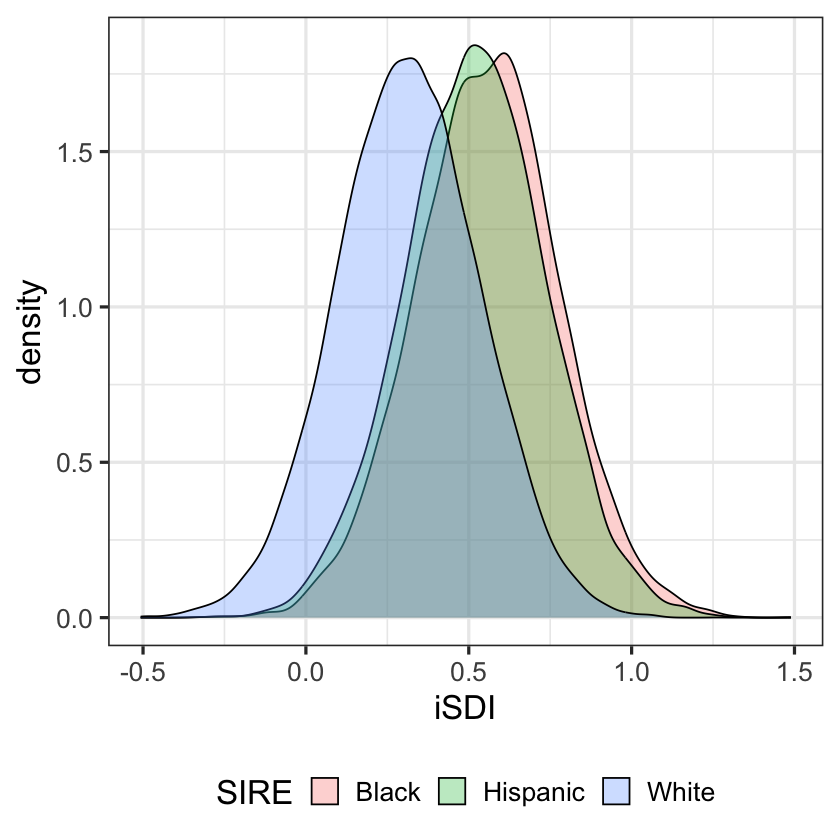

In [45]:
# Visualzie the density of age distribution.

ggplot(cohort, aes(x = iSDI, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

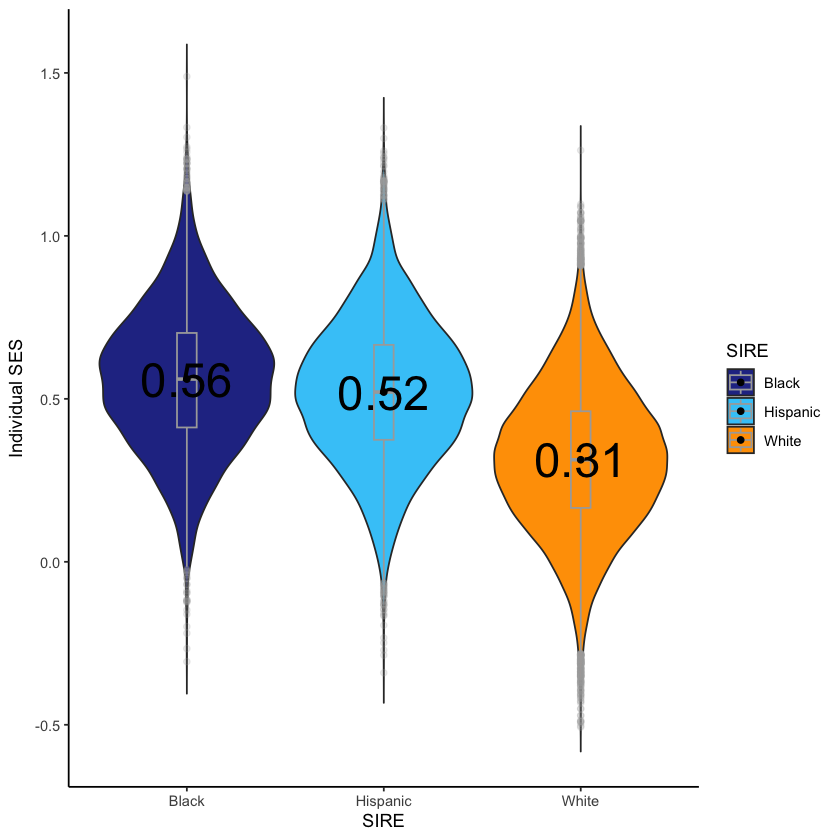

In [46]:
# Visualise the individual SES distribution across SIRE groups

library("ggplot2")
ggplot(cohort, aes(x=SIRE, y=iSDI, fill = SIRE)) + 
  geom_violin(trim = FALSE) + labs(x ="SIRE", y = "Individual SES")+
geom_boxplot(width=0.1, color="darkgrey", alpha=0.2) +
geom_text(data = cohort %>% group_by(SIRE) %>% summarise(median_V1 = median(iSDI, na.rm = TRUE)),
            aes(x = SIRE, y = median_V1, label = round(median_V1, 2)),
            size = 10, position = position_dodge(0.1))+
scale_fill_manual(values=c("#283593", "#41C9F8", "#FFA000"))+
stat_summary(fun = "median",
               geom = "point",
               color = "black")+
theme(panel.border = element_rect(colour = "black", fill=NA, size=0.5),
      axis.text.y   = element_text(size=100),
      axis.text.x   = element_text(size=100),
      axis.title.x = element_text(size=100),
      axis.title.y = element_text(size=100),
      legend.text=element_text(size=100))+
theme_classic() 

#### Conclusion
The median Individual Socioeconomic Deprivation of "White" SIRE group is least followed by "Black" and "Hispanic". This indicates that an individual's SES might be associated with their Self identified race and ethnicity. We model the association below to confirm.

### Modelling individual SES with SIRE

In [47]:
# Set Sex and SIRE as factors as they are categorical variables
cohort$Sex <- as.factor(cohort$Sex)  
cohort$SIRE <- as.factor(cohort$SIRE) 

#Set White Female as reference as we are studying disparities with reference to white ethnic group
cohort$Sex <- relevel(cohort$Sex, ref = "F")
cohort$SIRE <- relevel(cohort$SIRE, ref = "White")
model <-  glm(iSDI~SIRE+Age+Sex, data=cohort)
summary(model)


Call:
glm(formula = iSDI ~ SIRE + Age + Sex, data = cohort)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.86340  -0.14771  -0.00052   0.14569   0.94520  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.385100   0.005978  64.422   <2e-16 ***
SIREBlack     0.245328   0.002817  87.083   <2e-16 ***
SIREHispanic  0.211128   0.002483  85.022   <2e-16 ***
Age          -0.001667   0.000123 -13.550   <2e-16 ***
SexM          0.020093   0.002053   9.786   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.04785088)

    Null deviance: 2977.9  on 49999  degrees of freedom
Residual deviance: 2392.3  on 49995  degrees of freedom
AIC: -10082

Number of Fisher Scoring iterations: 2


#### Technical considerations
SIRE is a categorical variable and results are shown relative to "White" group. This can be changed in the code cell above in the levels argument.
Similarly for Sex, the results are show relative to female.
Age nd iSDI on the other hand is continuous, so think in terms of "every 1 unit increment"

#### Conclusions
SIRE = Black; A participant who identifies as Black in our dataset is likely to have 0.25 units higher iSDI compared to a participant who identifies as "White" while adjusted for sex and age
SIRE = Hispanic; 0.21 units higher
Sex = Male; Male participants tend to have 0.02 units higher iSDI than females within the SIRE groups and age ranges
Age; For every 1 year added, there is a decrease of 0.0017 units of iSDI levels in our dataset

From the above results it is clear that iSDI is significantly associated with black and hispanic SIRE

### Distribution of SED across SIRE groups with ANOVA

To determine whether or not there is a statistically significant difference between the means of the iSDI of the three SIRE groups we use one-way anova

In [48]:
anova_result <- aov(iSDI~SIRE,
  data = cohort
)
#Use the summary command to view the anova results
summary(anova_result)
summary(anova_result)[[1]]["Pr(>F)"]

               Df Sum Sq Mean Sq F value Pr(>F)    
SIRE            2  572.2  286.09    5946 <2e-16 ***
Residuals   49997 2405.7    0.05                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,Pr(>F)
,<dbl>
SIRE,0
Residuals,NA


Df SIRE: The degrees of freedom for the variable SIRE. This is calculated as #groups -1. In this case, there were 3 different SIRE groups, so this value is: 3-1 = 2.
Sum Sq SIRE: The sum of squares associated with the variable program. This value is 286.09.
F Value: The overall F-statistic of the ANOVA model. This is calculated as Mean Sq. SIRE / Mean sq. Residuals. In this case, it is calculated as: 286.09 / 0.05 = 5721.8.
The p-value associated with the F-statistic with numerator df = 2 and denominator df = 49997. In this case, the p-value is ~ 0 which is highly significant

### Modelling Disease Disparities

In [49]:
# Merge cohort and T2D
merged_cohort <- merge(cohort, T2D, on = ParticipantID)

In [50]:
head(merged_cohort)

,ParticipantID,SIRE,Sex,iSDI,Age,t2d
,<int>,<fct>,<fct>,<dbl>,<int>,<int>
1,10002913,White,F,-0.31416876,56,1
2,10004024,White,F,0.07031788,45,0
3,10004283,White,F,0.55632367,48,0
4,10008277,Hispanic,M,0.52996599,69,1
5,10008516,Hispanic,M,0.60678931,44,0
6,10009190,White,F,0.36417263,53,0


In [54]:
#calculate T2D prevalence per SIRE group
PrevalenceWhite <- sum(merged_cohort[merged_cohort$SIRE == "White", ]$t2d == 1)*100/nrow(merged_cohort[merged_cohort$SIRE == "White", ])
PrevalenceBlack <- sum(merged_cohort[merged_cohort$SIRE == "Black", ]$t2d == 1)*100/nrow(merged_cohort[merged_cohort$SIRE == "Black", ])
PrevalenceHispanic <- sum(merged_cohort[merged_cohort$SIRE == "Hispanic", ]$t2d == 1)*100/nrow(merged_cohort[merged_cohort$SIRE == "Hispanic", ])

PrevalenceWhite
PrevalenceBlack
PrevalenceHispanic

[1] 52.47614

[1] 56.49892

[1] 56.44589

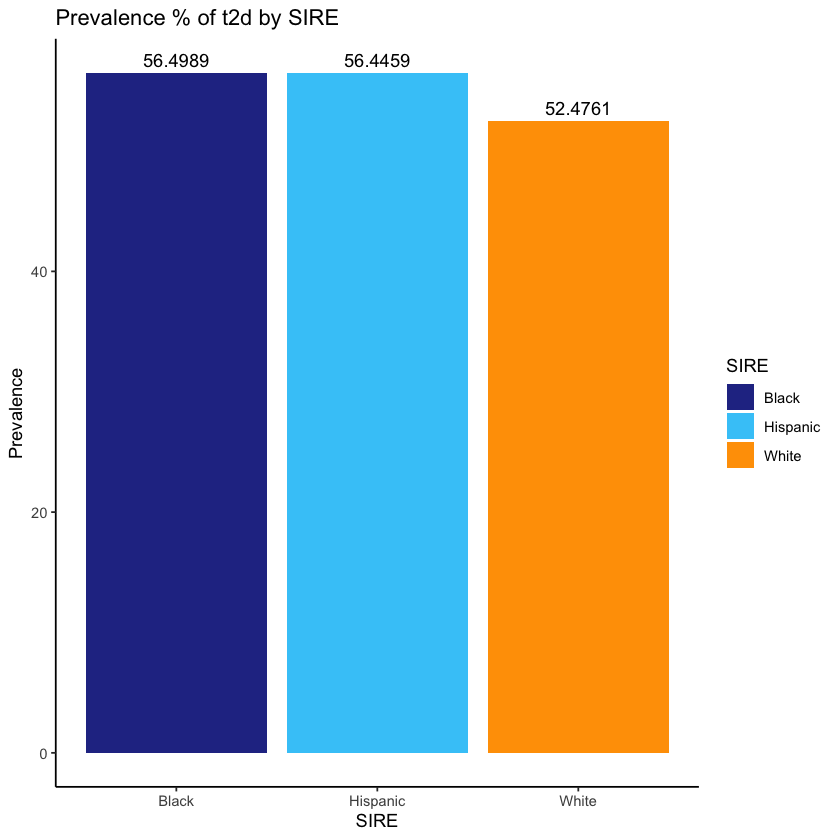

In [55]:
#create a bar plot
prevalence_data <- data.frame(
  SIRE = c("White", "Black", "Hispanic"),
  Prevalence = c(PrevalenceWhite, PrevalenceBlack, PrevalenceHispanic)
)

# Generate the bar plot using ggplot2
ggplot(prevalence_data, aes(x = SIRE, y = Prevalence, fill = SIRE)) +
  geom_bar(stat = "identity") +
  labs(title = "Prevalence % of t2d by SIRE",
       x = "SIRE",
       y = "Prevalence") +
  theme_classic() +
scale_fill_manual(values = c("White" = "#FFA000", "Black" = "#283593", "Hispanic" = "#41C9F8"))+
geom_text(aes(label = round(Prevalence, 4)), vjust = -0.5)

"Black" SIRE group has the highest prevalence followed by "Hispanic" and "White" SIRE group has the lowest T2D prevalence. In our All of Us cohort, the prevalences are - 17.21% for White SIRE group, 27.76% for Black SIRE group and 25.26% for Hispanic SIRE group

# Section 2 - Modelling T2D Disparities

In [56]:
# Modelling T2D without Individual SES
merged_cohort$Sex <- as.factor(merged_cohort$Sex)  
merged_cohort$SIRE <- as.factor(merged_cohort$SIRE) 

#Set White Female as reference as we are studying disparities with reference to white ethnci group
merged_cohort$Sex <- relevel(merged_cohort$Sex, ref = "F")
merged_cohort$SIRE <- relevel(merged_cohort$SIRE, ref = "White")

UnadjustedModel <-  glm(t2d~SIRE+Age+Sex, data=merged_cohort)
summary(UnadjustedModel)


Call:
glm(formula = t2d ~ SIRE + Age + Sex, data = merged_cohort)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6291  -0.5312   0.4211   0.4658   0.5266  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.4334028  0.0136012  31.865  < 2e-16 ***
SIREBlack    0.0389387  0.0064108   6.074 1.26e-09 ***
SIREHispanic 0.0363512  0.0056502   6.434 1.26e-10 ***
Age          0.0019020  0.0002799   6.794 1.10e-11 ***
SexM         0.0046039  0.0046723   0.985    0.324    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2479035)

    Null deviance: 12432  on 50031  degrees of freedom
Residual deviance: 12402  on 50027  degrees of freedom
AIC: 72211

Number of Fisher Scoring iterations: 2


#### Technical considerations
SIRE is a categorical variable and results are shown relative to "White" group. This can be changed in the code cell above in the levels argument.
Similarly for Sex, the results are show relative to female.
Age on the other hand is continuous, so think in terms of "every 1 unit increment"

#### Conclusions
SIRE = Black;  An individual who has SIRE as Black has 0.039 higher log odds of having T2D as compared to an individual whose SIRE is White.
SIRE = Hispanic; An individual who has SIRE as Hispanic has 0.036 higher log odds of having T2D as compared to an individual whose SIRE is White.
Sex = Male; Male participants tend to have 0.005 higher log odds of T2D than females within the SIRE groups and age ranges
Age; For every 1 year added, there is an increase of 0.0017 log odds of T2D

In [58]:
# Modelling T2D with Individual SES
AdjustedModel <-  glm(t2d~iSDI+SIRE+Age+Sex, data=merged_cohort)
summary(AdjustedModel)


Call:
glm(formula = t2d ~ iSDI + SIRE + Age + Sex, data = merged_cohort)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6366  -0.5321   0.4170   0.4643   0.5510  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.4112514  0.0141509  29.062  < 2e-16 ***
iSDI         0.0574921  0.0101744   5.651 1.61e-08 ***
SIREBlack    0.0248331  0.0068778   3.611 0.000306 ***
SIREHispanic 0.0242116  0.0060432   4.006 6.17e-05 ***
Age          0.0019982  0.0002804   7.127 1.04e-12 ***
SexM         0.0034447  0.0046753   0.737 0.461260    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2477503)

    Null deviance: 12432  on 50031  degrees of freedom
Residual deviance: 12394  on 50026  degrees of freedom
AIC: 72181

Number of Fisher Scoring iterations: 2


#### Technical considerations
SIRE is a categorical variable and results are shown relative to "White" group. This can be changed in the code cell above in the levels argument.
Similarly for Sex, the results are show relative to female.
Age and iSDI on the other hand is continuous, so think in terms of "every 1 unit increment"

#### Conclusions
SIRE = Black;  An individual who has SIRE as Black has 0.12 higher log odds of having T2D as compared to an individual whose SIRE is White.
SIRE = Hispanic; An individual who has SIRE as Hispanic has 0.14 higher log odds of having T2D as compared to an individual whose SIRE is White.
Sex = Male; Male participants tend to have 0.018 higher log odds of T2D than females within the SIRE groups and age ranges
Age; For every 1 year added, there is an increase of 0.006 log odds of T2D
iSDI; For every 1 unit added, there is an increase of 0.016 log odds of T2D

Adding individual SES decreases the coefficients of Black and Hispanic SIRE of the model indicating that iSDI explains some part of the T2D disparity

### Calculating attenuation

To what extent does the inclusion of individual socioeconomic deprivation in the model explain (attenuate) the effects of SIRE

In [61]:
Blackattenuation <- (summary(UnadjustedModel)$coefficients[2]-summary(AdjustedModel)$coefficients[3])/summary(UnadjustedModel)$coefficients[2]
Blackattenuation

Hispanicattenuation <- (summary(UnadjustedModel)$coefficients[3]-summary(AdjustedModel)$coefficients[4])/summary(UnadjustedModel)$coefficients[3]
Hispanicattenuation

[1] 0.3622508

[1] 0.3339535

#### Conclusion
iSDI attenuates T2D disparities by 36.2% and 33.3% for Black and Hisanic SIRE respectively

# Section 3 - Mediation Analysis

In [74]:
install.packages("mediation")


The downloaded binary packages are in
	/var/folders/6g/p69tpc2d2hq_fq8879ncn7540000gn/T//Rtmp3UVCG8/downloaded_packages


In [75]:
library(mediation)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loading required package: mvtnorm

Loading required package: sandwich

mediation: Causal Mediation Analysis
Version: 4.5.0




### Checking the extent to which individual SES mediates T2D disparities

In [76]:
#First model for indirect effect
med.fit<- lm(formula = as.formula("iSDI ~ SIRE + Age + Sex"), data = merged_cohort)
#Second model for indirect effect
out.fit <- glm(formula = as.formula("t2d ~ iSDI + SIRE + Age + Sex"), data = merged_cohort, family = "binomial")

In [77]:
med.out <-  mediate(med.fit, out.fit, treat = "SIRE", mediator = "iSDI", robustSE = TRUE, sims = 100)

Warning message in mediate(med.fit, out.fit, treat = "SIRE", mediator = "iSDI", :
“treatment and control values do not match factor levels; using White and Black as control and treatment, respectively”


In [78]:
summary(med.out)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)            0.01393      0.00979         0.02  <2e-16 ***
ACME (treated)            0.01380      0.00968         0.02  <2e-16 ***
ADE (control)             0.02470      0.01113         0.04  <2e-16 ***
ADE (treated)             0.02458      0.01106         0.04  <2e-16 ***
Total Effect              0.03850      0.02606         0.05  <2e-16 ***
Prop. Mediated (control)  0.36111      0.22630         0.59  <2e-16 ***
Prop. Mediated (treated)  0.35730      0.22324         0.59  <2e-16 ***
ACME (average)            0.01387      0.00974         0.02  <2e-16 ***
ADE (average)             0.02464      0.01110         0.04  <2e-16 ***
Prop. Mediated (average)  0.35921      0.22477         0.59  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 50032 


Simulations: 100 


#### Explanation 
ADE (Average controlled direct effect) : Average effect when comparing all treated (having a particular SIRE as compared to White refernce SIRE) to all untreated (individuals having white SIRE) and setting mediator (iSDI) to a specific level m. ADE answers the question that when we hold iSDI fixed to block any effect along the indirect pathway, what is the direct effect of black or hispanic SIRE groups.
ACME (Average controlled mediation effect) : 0.ACME is the estimated average increase in the dependent variable (T2D) that arrives as a result of the mediators rather than 'directly' from the treatment (Black or Hispanic SIRE).
Total effect : Total increase in probability of T2D in Black or Hispanic SIRE groups as compared to White SIRE group

#### Conclusion
Of the estimated 0.03850 (the Total Effect) increase in T2D disparity due to SIRE, an estimated 0.01387 (ACME (average)) is as a result of the socioeconomic deprivation (iSDI) changes generated by differing SIRE and the remaining 0.02464 (ADE (average)) is from SIRE itself.